# GLI3

In [1]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2024-08-13')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.9.1.dev0


### GLI3
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for GLI3.

In [2]:
gene_symbol = 'GLI3'
mane_tx_id = 'NM_000168.6'
mane_protein_id = 'NP_000159.3' # transcriptional activator GLI3 [Homo sapiens]

In [3]:
from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.20") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
print(f'Loaded {len(phenopackets)} phenopackets')

from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets
cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
validation.summarize()

Loaded 82 phenopackets
Individuals Processed: 100%|██████████| 82/82 [02:27<00:00,  1.80s/individuals]
Validated under permissive policy
No errors or warnings were found


In [5]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

n,HPO Term
37,Preaxial foot polydactyly
36,Postaxial hand polydactyly
32,Syndactyly
28,Macrocephaly
19,Broad thumb
18,Hypertelorism
17,Postaxial polydactyly
15,Y-shaped metacarpals
15,Y-shaped metatarsals
13,Shortening of all distal phalanges of the fingers


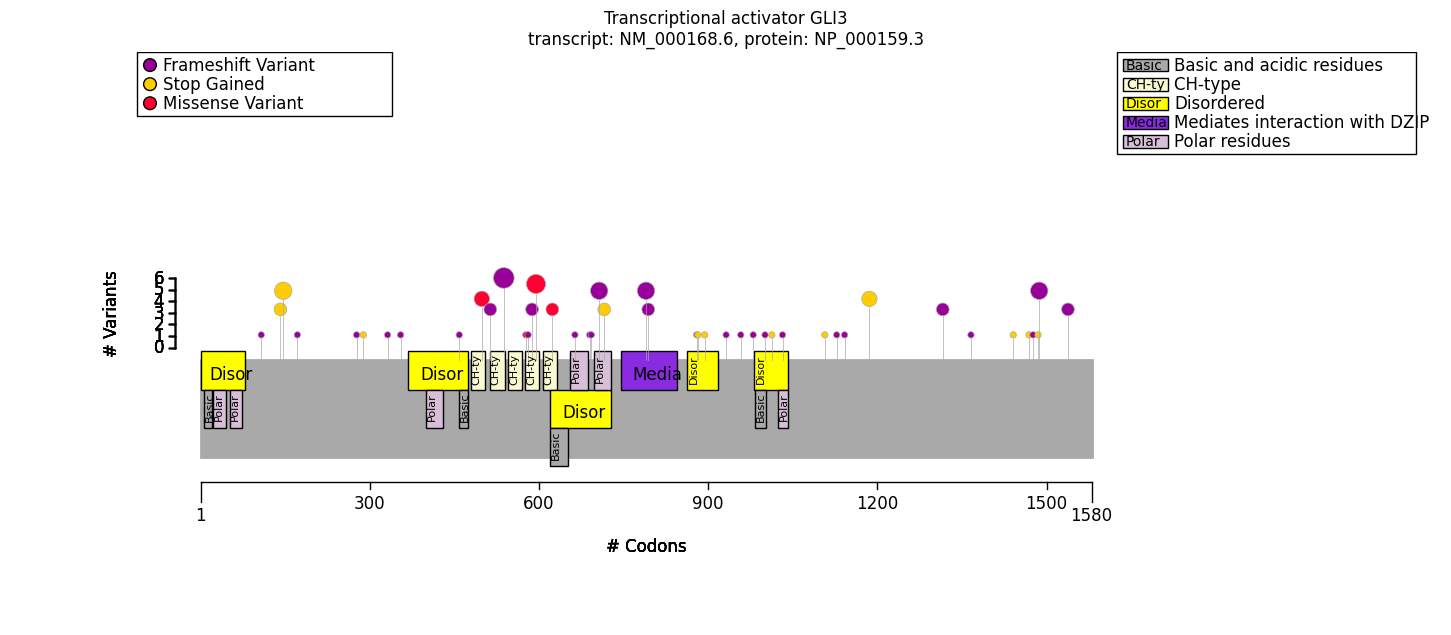

In [6]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

"""
protein_meta = ProteinMetadata.from_uniprot_json(
        protein_id=mane_protein_id,
        label="NKX6-2",
        uniprot_json="Q9C056.json",
        protein_length=550,
)
"""

fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fig.tight_layout()

In [8]:
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
from gpsea.analysis.pcats.stats import FisherExactTest
from gpsea.analysis.mtc_filter import HpoMtcFilter
from gpsea.analysis.pcats import HpoTermAnalysis

pheno_predicates = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

mtc_filter = HpoMtcFilter.default_filter(hpo=hpo, term_frequency_threshold=0.2)
mtc_correction = 'fdr_bh'
statistic = FisherExactTest()

analysis = HpoTermAnalysis(
    count_statistic=statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=0.05,
)

In [9]:
from gpsea.analysis.predicate import variant_effect
from gpsea.model import VariantEffect
from gpsea.analysis.clf import monoallelic_classifier


is_missense = variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)
gt_predicate = monoallelic_classifier(
    a_predicate=is_missense,
    b_predicate=~is_missense,
    a_label="missense",
    b_label="other"
)

In [10]:
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=gt_predicate,
    pheno_clfs=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.2,4
HMF03,Skipping term because of a child term with the same individual counts,4
HMF08,Skipping general term,43
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,96


In [11]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=result)

Allele group                                       missense          other  \
                                                      Count Percent  Count   
Preaxial foot polydactyly [HP:0001841]                10/11     91%  27/71   
Preaxial polydactyly [HP:0100258]                     10/10    100%  27/37   
Postaxial foot polydactyly [HP:0001830]                0/11      0%  11/44   
Y-shaped metatarsals [HP:0010567]                      0/11      0%  15/58   
Y-shaped metacarpals [HP:0006042]                      0/11      0%  15/68   
Postaxial hand polydactyly [HP:0001162]                4/11     36%  32/54   
Hypertelorism [HP:0000316]                             5/10     50%  13/42   
Syndactyly [HP:0001159]                                9/11     82%  29/44   
Macrocephaly [HP:0000256]                              5/11     45%  23/47   
Postaxial polydactyly [HP:0100259]                      4/4    100%  49/53   
Polydactyly [HP:0010442]                              10/10    100%  65/65   
Abnormal digit morphology [HP:0011297]                11/11    100%  69/69   
Abnormal appendicular skeleton morphology [HP:0...    11/11    100%  70/70   
Abnormal 5th finger morphology [HP:0004207]             4/4    100%  32/32   
Abnormal finger morphology [HP:0001167]                 5/5    100%  52/52   
Hand polydactyly [HP:0001161]                           4/4    100%  33/33   
Abnormal finger phalanx morphology [HP:0005918]         5/5    100%  52/52   
Abnormal hand morphology [HP:0005922]                   4/4    100%  53/53   
Abnormal hallux morphology [HP:0001844]               11/11    100%  34/34   
Abnormal toe morphology [HP:0001780]                  11/11    100%  41/41   
Foot polydactyly [HP:0001829]                         10/10    100%  34/34   

Allele group                                                                   \
                                                   Percent Corrected p values   
Preaxial foot polydactyly [HP:0001841]                 38%           0.040013   
Preaxial polydactyly [HP:0100258]                      73%           0.469995   
Postaxial foot polydactyly [HP:0001830]                25%           0.469995   
Y-shaped metatarsals [HP:0010567]                      26%           0.469995   
Y-shaped metacarpals [HP:0006042]                      22%           0.469995   
Postaxial hand polydactyly [HP:0001162]                59%           0.687602   
Hypertelorism [HP:0000316]                             31%           0.860356   
Syndactyly [HP:0001159]                                66%           1.000000   
Macrocephaly [HP:0000256]                              49%           1.000000   
Postaxial polydactyly [HP:0100259]                     92%           1.000000   
Polydactyly [HP:0010442]                              100%           1.000000   
Abnormal digit morphology [HP:0011297]                100%           1.000000   
Abnormal appendicular skeleton morphology [HP:0...    100%           1.000000   
Abnormal 5th finger morphology [HP:0004207]           100%           1.000000   
Abnormal finger morphology [HP:0001167]               100%           1.000000   
Hand polydactyly [HP:0001161]                         100%           1.000000   
Abnormal finger phalanx morphology [HP:0005918]       100%           1.000000   
Abnormal hand morphology [HP:0005922]                 100%           1.000000   
Abnormal hallux morphology [HP:0001844]               100%           1.000000   
Abnormal toe morphology [HP:0001780]                  100%           1.000000   
Foot polydactyly [HP:0001829]                         100%           1.000000   

Allele group                                                  
                                                    p values  
Preaxial foot polydactyly [HP:0001841]              0.001905  
Preaxial polydactyly [HP:0100258]                   0.091348  
Postaxial foot polydactyly [HP:0001830]             0.095939  
Y-shaped metatarsals [HP:0

In [13]:
from gpsea.analysis.clf import diagnosis_classifier
gt_predicate = diagnosis_classifier(
    diagnoses=('OMIM:175700', 'OMIM:146510'),
    labels=('Greig cephalopolysyndactyly syndrome', 'Pallister-Hall syndrome'),
)


In [14]:
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=gt_predicate,
    pheno_clfs=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=result)

Diagnosis                                          OMIM:175700          \
                                                         Count Percent   
Y-shaped metacarpals [HP:0006042]                         0/51      0%   
Y-shaped metatarsals [HP:0010567]                         0/51      0%   
Preaxial foot polydactyly [HP:0001841]                   37/51     73%   
Nail dysplasia [HP:0002164]                               0/51      0%   
Anal atresia [HP:0002023]                                 0/51      0%   
Postaxial polydactyly [HP:0100259]                       26/26    100%   
Postaxial hand polydactyly [HP:0001162]                  26/51     51%   
Postaxial foot polydactyly [HP:0001830]                  11/51     22%   
Polydactyly [HP:0010442]                                 48/48    100%   
Abnormal digit morphology [HP:0011297]                   50/50    100%   
Abnormal appendicular skeleton morphology [HP:0...       50/50    100%   
Abnormal finger morphology [HP:0001167]                  34/34    100%   
Abnormal finger phalanx morphology [HP:0005918]          34/34    100%   
Abnormal hand morphology [HP:0005922]                    27/27    100%   

Diagnosis                                          OMIM:146510          \
                                                         Count Percent   
Y-shaped metacarpals [HP:0006042]                        15/18     83%   
Y-shaped metatarsals [HP:0010567]                        15/18     83%   
Preaxial foot polydactyly [HP:0001841]                    0/21      0%   
Nail dysplasia [HP:0002164]                               9/13     69%   
Anal atresia [HP:0002023]                                10/21     48%   
Postaxial polydactyly [HP:0100259]                       17/21     81%   
Postaxial hand polydactyly [HP:0001162]                    0/4      0%   
Postaxial foot polydactyly [HP:0001830]                    0/4      0%   
Polydactyly [HP:0010442]                                 17/17    100%   
Abnormal digit morphology [HP:0011297]                   20/20    100%   
Abnormal appendicular skeleton morphology [HP:0...       21/21    100%   
Abnormal finger morphology [HP:0001167]                  13/13    100%   
Abnormal finger phalanx morphology [HP:0005918]          13/13    100%   
Abnormal hand morphology [HP:0005922]                    20/20    100%   

Diagnosis                                                              \
                                                   Corrected p values   
Y-shaped metacarpals [HP:0006042]                        1.007625e-11   
Y-shaped metatarsals [HP:0010567]                        1.007625e-11   
Preaxial foot polydactyly [HP:0001841]                   1.401136e-08   
Nail dysplasia [HP:0002164]                              9.086590e-08   
Anal atresia [HP:0002023]                                1.841818e-06   
Postaxial polydactyly [HP:0100259]                       7.829451e-02   
Postaxial hand polydactyly [HP:0001162]                  2.269487e-01   
Postaxial foot polydactyly [HP:0001830]                  1.000000e+00   
Polydactyly [HP:0010442]                                 1.000000e+00   
Abnormal digit morphology [HP:0011297]                   1.000000e+00   
Abnormal appendicular skeleton morphology [HP:0...       1.000000e+00   
Abnormal finger morphology [HP:0001167]                  1.000000e+00   
Abnormal finger phalanx morphology [HP:0005918]          1.000000e+00   
Abnormal hand morphology [HP:0005922]                    1.000000e+00   

Diagnosis                                                         
                                                        p values  
Y-shaped metacarpals [HP:0006042]                   1.439464e-12  
Y-shaped metatarsals [HP:0010567]                   1.439464e-12  
Preaxial foot polydactyly [HP:0001841]              3.002434e-09  
Nail dysplasia [HP:0002164]                         2.596169e-08  
Anal atresia [HP:0002023]                           6.57792